1. [Testing calc_rsq](#Testing-calc_rsq)
    1. [Generating Random Correlation Matrices](#Generate-random-correlation-matrices)
    2. [Real Data](#Real-Data)
    3. [Try out the new icc function too](#Try-out-the-new-icc-function-too)
3. [Testing data sampling scheme](#Testing-data-sampling-scheme)

# Testing `calc_rsq`

We're getting weird results from our iterations, so let's see what's going on. I'm going to run through this code in python2 and python3.

In [1]:
import sys
print (sys.version)

2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def exclude_nan(x,y):
    """
    Exclude NaN values if either entry in a pair of vectors has NaN
    """
    idx = np.logical_not(np.logical_or(np.isnan(x), np.isnan(y)))
    x = x[idx]
    y = y[idx]
    n = len(x)
    return [x, y, n]

def compute_icc(av_corr_mat_A, av_corr_mat_B):
    """
    This function computes the inter-class correlation (ICC) of the
    two classes represented by the x and y numpy vectors.
    """

    inds = np.triu_indices_from(av_corr_mat_B, k=1)
    x = av_corr_mat_A[inds]
    y = av_corr_mat_B[inds]
    
    if all(x == y):
        return 1

    [x, y, n] = exclude_nan(x,y)

    ## Need at least 3 data points to compute this
    if n < 3:
        return np.nan

    Sx = sum(x); Sy = sum(y);
    Sxx = sum(x*x); Sxy = sum( (x+y)**2 )/2; Syy = sum(y*y)

    fact = ((Sx + Sy)**2)/(n*2)
    SS_tot = Sxx + Syy - fact
    SS_among = Sxy - fact
    SS_error = SS_tot - SS_among

    MS_error = SS_error/n
    MS_among = SS_among/(n-1)
    ICC = (MS_among - MS_error) / (MS_among + MS_error)

    return ICC

In [4]:
def calc_rsq(av_corr_mat_A, av_corr_mat_B):
    """
    From wikipedia: https://en.wikipedia.org/wiki/Coefficient_of_determination
    
    Rsq = 1 - (SSres / SStot)
    
    SSres is calculated as the sum of square errors (where the error
    is the difference between x and y).
    
    SStot is calculated as the total sum of squares in y.
    """
    # Get the data we need
    inds = np.triu_indices_from(av_corr_mat_B, k=1)
    x = av_corr_mat_A[inds]
    y = av_corr_mat_B[inds]
    
    # Calculate the error/residuals
    res = y - x

    SSres = np.sum(res**2)
    
    # Sum up the total error in y
    y_var = y - np.mean(y)
    
    SStot = np.sum(y_var**2)
    
    # R squared
    Rsq = 1 - (SSres/SStot)
    
    return Rsq

## Generate random correlation matrices

In [5]:
df1 = pd.DataFrame(np.random.normal(0, 1, size=(100, 20)))
df2 = pd.DataFrame(np.random.normal(0, 1, size=(100, 20)))
df1corrmat = df1.corr()
df2corrmat = df2.corr()

In [6]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.668934,-0.884572,0.744784,-0.572057,-0.259961,0.721067,0.031031,-0.963575,-0.382446,0.571484,0.593464,0.115446,-0.263857,1.068015,0.716425,-0.292876,0.783389,0.196551,-0.521940,-0.494695
1,0.111246,0.088492,-1.327671,0.928194,-1.133158,0.218997,-0.819130,1.038457,-0.813633,-0.385840,1.218551,-0.059480,0.402007,1.262557,1.317373,-0.684457,-0.589373,0.087214,-0.444488,-0.469957
2,0.653867,-0.080116,-0.156270,0.414770,-0.058739,-0.239175,1.132528,-0.132889,-1.237418,-1.203316,-0.541725,0.244538,-0.558937,-1.195318,-0.663466,-1.909617,0.787848,0.391414,-0.631742,0.781861
3,-1.339499,1.855918,-0.615255,-0.963850,0.398589,0.856164,0.623541,1.316290,-0.601617,-0.004499,1.018353,-0.014170,-0.397869,-0.652185,-0.122210,1.370167,-0.023173,-2.641827,1.089703,0.446839
4,0.348964,0.853290,-0.328265,0.099400,-0.084147,0.938800,2.128478,-0.790298,1.472801,-3.204137,-0.175313,1.983924,-0.608306,-1.245945,0.531912,-0.803776,-0.561445,-1.289553,0.660253,0.225929


In [7]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.103625,1.503288,-0.654842,0.325861,-0.359159,-1.161519,-0.487125,-0.037166,0.718197,-0.105363,0.202489,-1.285893,-1.106918,-0.990233,-0.266008,-1.982091,-0.680166,0.701885,0.987990,-0.111962
1,1.230978,-0.315063,-0.726004,-0.320753,0.232302,0.922624,0.607691,0.586845,0.024253,0.010022,-0.743898,-0.471640,0.640736,-2.232569,0.300128,0.223617,1.195353,1.335122,0.127480,0.935913
2,0.426937,0.847327,-0.858192,2.184520,-0.794352,-1.190010,0.577048,-0.262060,-0.799889,-1.847503,0.281549,1.286418,-2.397412,-0.108802,-0.170476,-1.431504,2.040260,-0.007799,-0.757439,0.899482
3,0.834844,-1.002510,-1.362354,1.392584,1.839889,-0.328847,0.489699,0.853879,1.023011,-2.827354,-0.417220,-0.747251,2.378550,0.288147,0.101578,-1.195409,0.952862,-1.047905,1.621791,-0.210062
4,1.007560,-1.247040,-0.549959,0.374505,0.560633,2.534416,0.612278,1.102921,-0.425551,-0.246701,-0.517533,0.324909,0.580426,4.407041,-0.823633,0.608025,2.125364,1.893956,0.340677,0.168246


In [8]:
df1corrmat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,-0.088054,0.006151,-0.025285,0.095737,0.139365,0.062043,-0.076499,0.111736,-0.140576,-0.005398,-0.020475,0.017023,-0.101126,0.062672,-0.115003,-0.038171,0.035216,-0.048119,0.095489
1,-0.088054,1.000000,0.012657,0.131007,0.039733,0.007385,-0.138121,-0.072969,0.044023,0.061492,0.055676,-0.147106,-0.196441,-0.092749,-0.007212,-0.070872,-0.027045,-0.045008,0.135768,0.057994
2,0.006151,0.012657,1.000000,-0.044933,0.030006,-0.046961,0.116022,0.019683,0.039824,-0.105470,0.117655,-0.003318,-0.082474,-0.000237,0.027455,-0.005976,0.083207,-0.034555,0.053223,0.185039
3,-0.025285,0.131007,-0.044933,1.000000,-0.096893,0.014625,-0.164449,0.100322,-0.068844,-0.079719,-0.076404,-0.177160,-0.054521,0.023228,-0.084676,-0.019811,-0.070464,-0.049337,-0.159871,0.084713
4,0.095737,0.039733,0.030006,-0.096893,1.000000,-0.183924,-0.047286,-0.141442,-0.071833,0.012960,0.081708,-0.017804,-0.057991,0.089984,0.109586,-0.058594,-0.159591,-0.364558,-0.021742,0.011712


In [9]:
df2corrmat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,-0.088908,-0.052612,-0.000539,-0.085662,0.226414,-0.031673,-0.251725,0.011062,-0.038445,0.032931,-0.139518,-0.067934,0.053559,-0.013296,0.006223,0.032406,0.085716,0.041360,-0.059873
1,-0.088908,1.000000,-0.009775,0.076488,0.118419,-0.007160,-0.012525,-0.081440,-0.158012,0.013303,-0.023052,0.191431,-0.145447,-0.020349,0.066269,0.021337,-0.052661,0.128975,-0.133916,-0.085084
2,-0.052612,-0.009775,1.000000,-0.033862,0.000498,-0.161077,-0.001492,0.017011,-0.104922,0.051564,-0.094387,-0.076440,0.012651,-0.028911,0.040062,-0.143283,-0.141822,-0.001545,-0.174179,-0.063809
3,-0.000539,0.076488,-0.033862,1.000000,-0.080617,-0.232538,0.141082,0.039046,0.042775,0.171606,-0.085792,-0.007614,0.003814,0.178350,0.125331,-0.084826,0.076330,0.146409,0.147810,-0.043780
4,-0.085662,0.118419,0.000498,-0.080617,1.000000,0.010879,0.024403,0.112917,-0.000299,-0.056144,0.107576,0.166520,0.104362,0.041069,0.056141,0.176073,-0.179727,-0.029405,0.036037,-0.169216


### Calculate $R^2$ from random matrices

In [10]:
calc_rsq(df1.corr().as_matrix(), df2.corr().as_matrix())

-1.1978816052732975

Now let's walk through the code above to see what it's doing.

In [11]:
inds = np.triu_indices_from( df2.corr().as_matrix(), k=1)
inds

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13,
        13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16,
        17, 17, 18]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14

In [12]:
x =  df1.corr().as_matrix()[inds]
y =  df2.corr().as_matrix()[inds]

In [13]:
print(str(df1.corr().shape) + " matrix gives an upper triangle with length " + str((20*(20-1))/2))

(20, 20) matrix gives an upper triangle with length 190


`df.corr()` is a $20\times 20$ matrix, so getting the upper triangle should give us $\frac{20\cdot (20-1)}{2}=190$ cells in the upper triangle.

In [14]:
len(x)

190

Yay, we get what we expect!

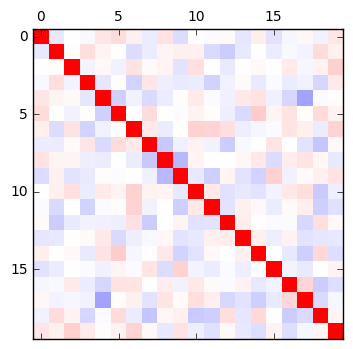

In [15]:
plt.matshow(df1.corr(), vmin=-1, vmax=1, cmap='bwr')

In [16]:
df1.corr().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.00,-0.09,0.01,-0.03,0.10,0.14,0.06,-0.08,0.11,-0.14,-0.01,-0.02,0.02,-0.10,0.06,-0.12,-0.04,0.04,-0.05,0.10
1,-0.09,1.00,0.01,0.13,0.04,0.01,-0.14,-0.07,0.04,0.06,0.06,-0.15,-0.20,-0.09,-0.01,-0.07,-0.03,-0.05,0.14,0.06
2,0.01,0.01,1.00,-0.04,0.03,-0.05,0.12,0.02,0.04,-0.11,0.12,-0.00,-0.08,-0.00,0.03,-0.01,0.08,-0.03,0.05,0.19
3,-0.03,0.13,-0.04,1.00,-0.10,0.01,-0.16,0.10,-0.07,-0.08,-0.08,-0.18,-0.05,0.02,-0.08,-0.02,-0.07,-0.05,-0.16,0.08
4,0.10,0.04,0.03,-0.10,1.00,-0.18,-0.05,-0.14,-0.07,0.01,0.08,-0.02,-0.06,0.09,0.11,-0.06,-0.16,-0.36,-0.02,0.01
5,0.14,0.01,-0.05,0.01,-0.18,1.00,0.00,0.14,0.01,-0.01,0.05,0.01,-0.07,-0.14,0.20,0.04,0.11,0.01,0.14,0.05
6,0.06,-0.14,0.12,-0.16,-0.05,0.00,1.00,0.08,-0.08,0.00,0.18,0.17,0.12,-0.07,-0.04,-0.02,0.11,0.06,-0.07,0.17
7,-0.08,-0.07,0.02,0.10,-0.14,0.14,0.08,1.00,-0.21,-0.06,0.05,-0.05,-0.20,-0.03,-0.00,0.10,0.01,-0.10,-0.22,0.03
8,0.11,0.04,0.04,-0.07,-0.07,0.01,-0.08,-0.21,1.00,-0.28,0.04,0.00,0.01,0.03,0.09,-0.13,0.08,0.11,0.04,-0.09
9,-0.14,0.06,-0.11,-0.08,0.01,-0.01,0.00,-0.06,-0.28,1.00,-0.09,-0.19,0.05,-0.11,-0.17,0.17,-0.05,0.02,0.06,0.12


In [17]:
x.round(2)

array([-0.09,  0.01, -0.03,  0.1 ,  0.14,  0.06, -0.08,  0.11, -0.14,
       -0.01, -0.02,  0.02, -0.1 ,  0.06, -0.12, -0.04,  0.04, -0.05,
        0.1 ,  0.01,  0.13,  0.04,  0.01, -0.14, -0.07,  0.04,  0.06,
        0.06, -0.15, -0.2 , -0.09, -0.01, -0.07, -0.03, -0.05,  0.14,
        0.06, -0.04,  0.03, -0.05,  0.12,  0.02,  0.04, -0.11,  0.12,
       -0.  , -0.08, -0.  ,  0.03, -0.01,  0.08, -0.03,  0.05,  0.19,
       -0.1 ,  0.01, -0.16,  0.1 , -0.07, -0.08, -0.08, -0.18, -0.05,
        0.02, -0.08, -0.02, -0.07, -0.05, -0.16,  0.08, -0.18, -0.05,
       -0.14, -0.07,  0.01,  0.08, -0.02, -0.06,  0.09,  0.11, -0.06,
       -0.16, -0.36, -0.02,  0.01,  0.  ,  0.14,  0.01, -0.01,  0.05,
        0.01, -0.07, -0.14,  0.2 ,  0.04,  0.11,  0.01,  0.14,  0.05,
        0.08, -0.08,  0.  ,  0.18,  0.17,  0.12, -0.07, -0.04, -0.02,
        0.11,  0.06, -0.07,  0.17, -0.21, -0.06,  0.05, -0.05, -0.2 ,
       -0.03, -0.  ,  0.1 ,  0.01, -0.1 , -0.22,  0.03, -0.28,  0.04,
        0.  ,  0.01,

These also match, so that's good. Time to walk through the $R^2$ calculation.

In [18]:
res = y - x
res

array([-0.00085341, -0.05876251,  0.02474638, -0.18139898,  0.0870487 ,
       -0.09371635, -0.17522562, -0.10067371,  0.10213125,  0.038329  ,
       -0.11904275, -0.08495733,  0.15468572, -0.07596762,  0.12122579,
        0.07057688,  0.05049992,  0.0894793 , -0.15536151, -0.02243256,
       -0.05451899,  0.07868565, -0.01454532,  0.12559675, -0.00847082,
       -0.20203458, -0.0481896 , -0.07872841,  0.33853628,  0.05099436,
        0.0724001 ,  0.07348157,  0.09220929, -0.02561595,  0.17398336,
       -0.26968349, -0.14307786,  0.01107099, -0.02950864, -0.11411656,
       -0.11751389, -0.00267207, -0.14474536,  0.15703426, -0.21204237,
       -0.0731224 ,  0.09512541, -0.02867383,  0.01260777, -0.13730673,
       -0.22502865,  0.03301043, -0.22740182, -0.24884859,  0.0162763 ,
       -0.2471629 ,  0.30553143, -0.0612765 ,  0.11161977,  0.25132455,
       -0.00938758,  0.16954605,  0.05833518,  0.15512145,  0.21000674,
       -0.06501473,  0.14679389,  0.19574616,  0.30768095, -0.12

In [19]:
SSres = np.sum(res**2)
SSres

4.0753095954763339

In [20]:
# Sum up the total error in y
y_var = y - np.mean(y)
y_var

array([-0.09230689, -0.05601125, -0.00393814, -0.08906098,  0.22301484,
       -0.03507278, -0.25512396,  0.00766285, -0.04184427,  0.02953176,
       -0.14291732, -0.07133346,  0.05016002, -0.0166954 ,  0.00282344,
        0.02900696,  0.08231698,  0.03796063, -0.06327187, -0.01317459,
        0.07308837,  0.11501962, -0.01055916, -0.01592397, -0.0848395 ,
       -0.16141136,  0.0099033 , -0.02645165,  0.18803145, -0.14884625,
       -0.02374817,  0.06286983,  0.01793801, -0.0560601 ,  0.1255757 ,
       -0.13731488, -0.08848331, -0.03726153, -0.00290176, -0.16447669,
       -0.00489105,  0.01361164, -0.10832102,  0.04816489, -0.09778676,
       -0.07983977,  0.00925193, -0.03231044,  0.03666297, -0.14668226,
       -0.1452209 , -0.00494434, -0.17757826, -0.06720852, -0.08401599,
       -0.23593692,  0.13768314,  0.03564652,  0.03937605,  0.16820619,
       -0.08919095, -0.01101298,  0.00041506,  0.17495034,  0.12193169,
       -0.08822535,  0.07293026,  0.14300996,  0.14441056, -0.04

In [21]:
SStot = np.sum(y_var**2)
SStot

1.8541988729959755

In [22]:
# R squared
Rsq = 1 - (SSres/SStot)
Rsq

-1.1978816052732975

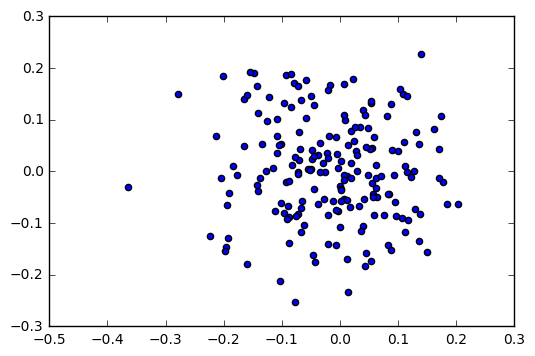

In [23]:
plt.scatter(x, y)

### Conclusion

Python 3: This works as expected, but we had to use `as_matrix()` to get it to not error in `calc_rsq()`.
Python 2: This works as expected, but we had to use `as_matrix()` to get it to not error in `calc_rsq()`.

# Real Data

In [24]:
behav_data_f = 'Phenotypic_V1_0b_preprocessed1.csv'

In [25]:
df = pd.read_csv(behav_data_f)
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])
df.head()

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,AGE_YRS
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,24.0
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,19.0
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0,13.0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1,13.0
5,5,6,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,...,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1,17.0


In [26]:
nsubs = 100
start1 = 0
start2 = 100
for i, (sub, f_id) in enumerate(df.loc[start1:(start1+nsubs),['SUB_ID', 'FILE_ID']].values):
    #read each subjects aal roi time series files
    ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

    #create a correlation matrix from the roi all time series files
    corr_mat = ts_df.corr()

    #for the first subject, add a correlation matrix of zeros that is the same dimensions as the aal roi-roi matrix
    if i == 0:
        all_corr_mat1 = np.empty([corr_mat.shape[0], corr_mat.shape[1], nsubs])

    #now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
    all_corr_mat1[:, :, i] = corr_mat

#create the mean correlation matrix (ignore nas - sometime there are some...)
av_corr_mat1 = np.nanmean(all_corr_mat1, axis=2)

for i, (sub, f_id) in enumerate(df.loc[start2:(start2+nsubs),['SUB_ID', 'FILE_ID']].values):
    #read each subjects aal roi time series files
    ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

    #create a correlation matrix from the roi all time series files
    corr_mat = ts_df.corr()

    #for the first subject, add a correlation matrix of zeros that is the same dimensions as the aal roi-roi matrix
    if i == 0:
        all_corr_mat2 = np.empty([corr_mat.shape[0], corr_mat.shape[1], nsubs])

    #now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
    all_corr_mat2[:, :, i] = corr_mat

#create the mean correlation matrix (ignore nas - sometime there are some...)
av_corr_mat2 = np.nanmean(all_corr_mat2, axis=2)

In [27]:
[all_corr_mat1.shape, all_corr_mat2.shape]

[(116, 116, 100), (116, 116, 100)]

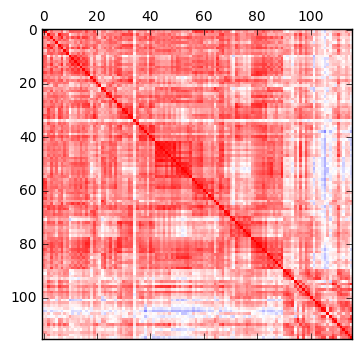

In [28]:
plt.matshow(all_corr_mat1[:,:,0], vmin=-1, vmax=1, cmap='bwr')

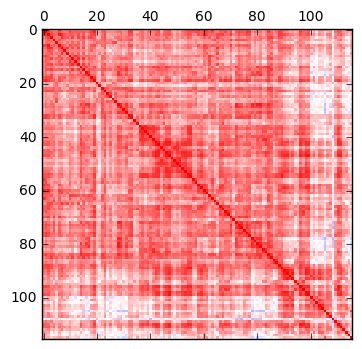

In [29]:
plt.matshow(all_corr_mat1[:,:,9], vmin=-1, vmax=1, cmap='bwr')

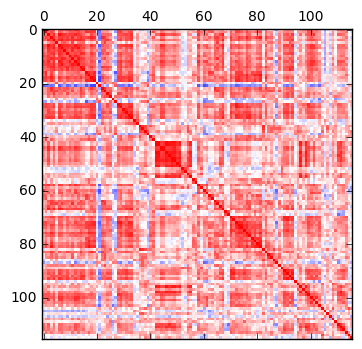

In [30]:
plt.matshow(all_corr_mat2[:,:,0], vmin=-1, vmax=1, cmap='bwr')

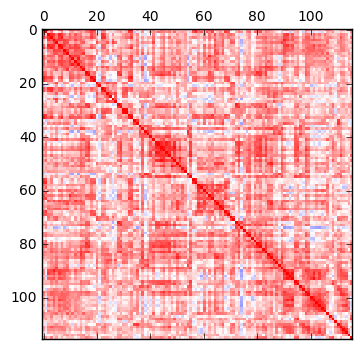

In [31]:
plt.matshow(all_corr_mat2[:,:,9], vmin=-1, vmax=1, cmap='bwr')

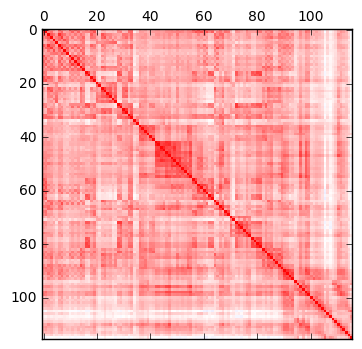

In [32]:
plt.matshow(av_corr_mat1, vmin=-1, vmax=1, cmap='bwr')

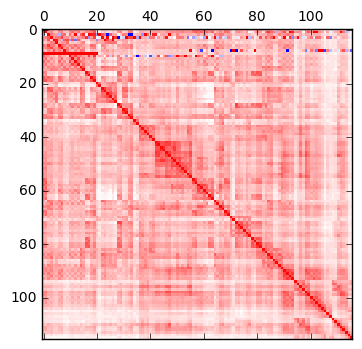

In [33]:
plt.matshow(av_corr_mat2, vmin=-1, vmax=1, cmap='bwr')

In [34]:
np.fill_diagonal(av_corr_mat1, 0)
np.fill_diagonal(av_corr_mat2, 0)

np.round([(av_corr_mat1.min(), av_corr_mat1.max()), (av_corr_mat2.min(), av_corr_mat2.max())])

array([[ -0.00000000e+000,   1.00000000e+000],
       [ -8.07300046e+295,   2.15223028e+135]])

In [35]:
np.fill_diagonal(all_corr_mat1[:,:,89], 0)
np.fill_diagonal(all_corr_mat1[:,:,66], 0)

np.round([(all_corr_mat1[:,:,89].min(), all_corr_mat1[:,:,89].max()), (all_corr_mat1[:,:,66].min(), all_corr_mat1[:,:,66].max())], 2)

array([[-0.27,  0.94],
       [-0.53,  0.93]])

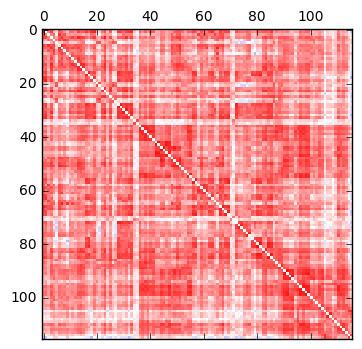

In [36]:
plt.matshow(all_corr_mat1[:,:,89], vmin=-1, vmax=1, cmap='bwr')

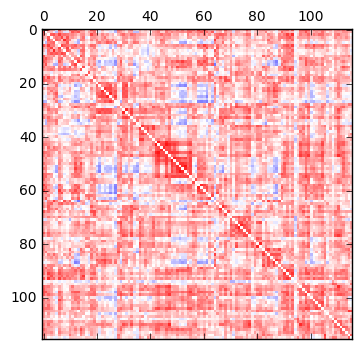

In [37]:
plt.matshow(all_corr_mat1[:,:,66], vmin=-1, vmax=1, cmap='bwr')

In [38]:
calc_rsq(av_corr_mat1, av_corr_mat2)

nan

Apparently we need to Fisher *z* transform them, which is equivalent to the arctanh function.

In [39]:
nsubs = 100
start1 = 0
start2 = 100
for i, (sub, f_id) in enumerate(df.loc[start1:(start1+nsubs),['SUB_ID', 'FILE_ID']].values):
    #read each subjects aal roi time series files
    ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

    #create a correlation matrix from the roi all time series files
    corr_mat_r = ts_df.corr()
    corr_mat_z = np.arctanh(corr_mat_r)

    #for the first subject, add a correlation matrix of zeros that is the same dimensions as the aal roi-roi matrix
    if i == 0:
        all_corr_mat1_z = np.zeros([corr_mat_z.shape[0], corr_mat_z.shape[1], nsubs])

    #now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
    all_corr_mat1_z[:, :, i] = corr_mat_z

#create the mean correlation matrix (ignore nas - sometime there are some...)
av_corr_mat1_z = np.nanmean(all_corr_mat1_z, axis=2)

for i, (sub, f_id) in enumerate(df.loc[start2:(start2+nsubs),['SUB_ID', 'FILE_ID']].values):
    #read each subjects aal roi time series files
    ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

    #create a correlation matrix from the roi all time series files
    corr_mat_r = ts_df.corr()
    corr_mat_z = np.arctanh(corr_mat_r)
    
    #for the first subject, add a correlation matrix of zeros that is the same dimensions as the aal roi-roi matrix
    if i == 0:
        all_corr_mat2_z = np.zeros([corr_mat_z.shape[0], corr_mat_z.shape[1], nsubs])

    #now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
    all_corr_mat2_z[:, :, i] = corr_mat_z

#create the mean correlation matrix (ignore nas - sometime there are some...)
av_corr_mat2_z = np.nanmean(all_corr_mat2_z, axis=2)

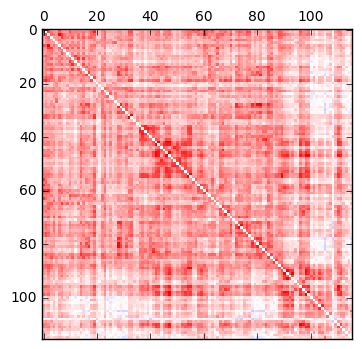

In [40]:
plt.matshow(all_corr_mat1_z[:,:,9], vmin=-1.5, vmax=1.5, cmap='bwr')

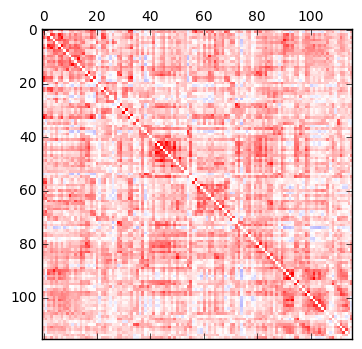

In [41]:
plt.matshow(all_corr_mat2_z[:,:,9], vmin=-1.5, vmax=1.5, cmap='bwr')

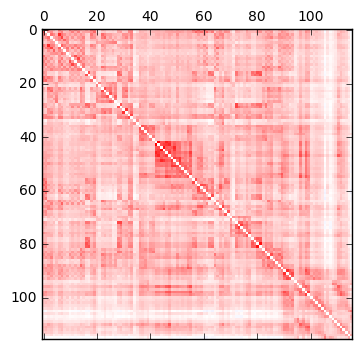

In [42]:
plt.matshow(av_corr_mat1_z, vmin=-1.5, vmax=1.5, cmap='bwr')

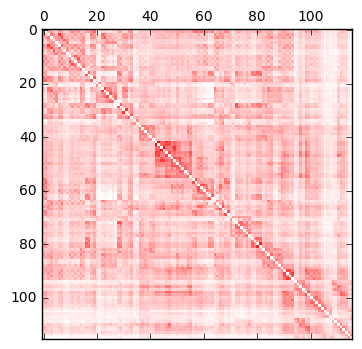

In [43]:
plt.matshow(av_corr_mat2_z, vmin=-1.5, vmax=1.5, cmap='bwr')

In [44]:
np.fill_diagonal(av_corr_mat1_z, 0)
np.fill_diagonal(av_corr_mat2_z, 0)

np.round([(av_corr_mat1_z.min(), av_corr_mat1_z.max()), (av_corr_mat2_z.min(), av_corr_mat2_z.max())],4)

array([[-0.0752,  1.6009],
       [-0.0198,  1.4522]])

In [45]:
calc_rsq(av_corr_mat1_z, av_corr_mat2_z)

0.82211375388083741

In [46]:
calc_rsq(np.random.normal(0,.0001, size=(190,190)), np.random.normal(0,.0001, size=(190,190)))

-0.98038879791065803

In [47]:
covmat = np.zeros((190, 190))
means = np.zeros(190)
np.fill_diagonal(covmat, 1)
datas1=pd.DataFrame(data=np.random.multivariate_normal(means, covmat, size=100))
datas2=pd.DataFrame(data=np.random.multivariate_normal(means, covmat, size=100))
datas1.shape

(100, 190)

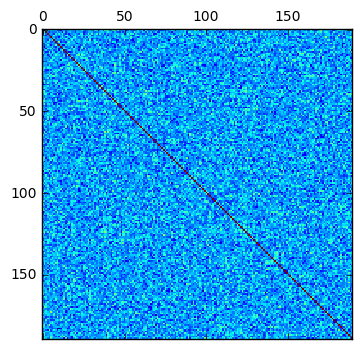

In [48]:
plt.matshow(datas1.corr())

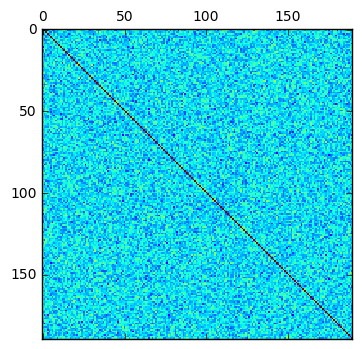

In [49]:
plt.matshow(datas2.corr())

In [50]:
calc_rsq(datas1.corr().as_matrix(), datas2.corr().as_matrix())

-1.0029114470470324

## Try out the new icc function too

In [51]:
compute_icc(datas1.corr().as_matrix(), datas2.corr().as_matrix())

0.013915371162962606

In [52]:
compute_icc(av_corr_mat1_z, av_corr_mat2_z)

0.92101435582748625

# Testing data sampling scheme

In [53]:
behav_data_f = 'Phenotypic_V1_0b_preprocessed1.csv'

In [54]:
df = pd.read_csv(behav_data_f)
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])
df.head()

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,AGE_YRS
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,24.0
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,19.0
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0,13.0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1,13.0
5,5,6,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,...,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1,17.0


In [55]:
motion_thresh = 10

In [56]:
# Start by removing all participants whose data is below a certain
# motion threshold.
df_samp_motion = df.loc[df['func_perc_fd'] < motion_thresh, :]
df_samp_motion.head()

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,AGE_YRS
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1,13.0
7,7,8,50009,8,50009,PITT,Pitt_0050009,1,1,33.86,...,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,OK,NaN,1,33.0
8,8,9,50010,9,50010,PITT,Pitt_0050010,1,1,35.20,...,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1,35.0
9,9,10,50011,10,50011,PITT,Pitt_0050011,1,1,16.93,...,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,0,16.0
10,10,11,50012,11,50012,PITT,Pitt_0050012,1,1,21.48,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,21.0


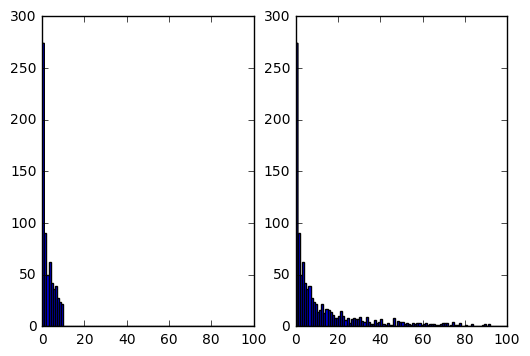

In [57]:
plt.figure(1)
plt.subplot(121)
plt.hist(df_samp_motion.func_perc_fd, range=(0,100), bins=100)
plt.subplot(122)
blah = plt.hist(df.func_perc_fd, range=(0,100), bins=100)

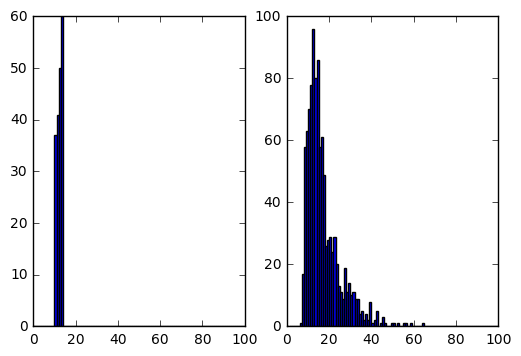

In [58]:
age_l=10
age_u=age_l+3
# Then remove participants who are younger (in years) than age_l and older
# than age_u. Note that this means people who are age_l and age_u
# (eg 6 and 10) will be included in the sample.
df_samp = df_samp_motion.loc[(df_samp_motion['AGE_YRS']>=age_l)
                                & (df_samp_motion['AGE_YRS']<=age_u), :]
plt.figure(1)
plt.subplot(121)
plt.hist(df_samp.AGE_YRS, range=(0,100), bins=100)
plt.subplot(122)
blah = plt.hist(df.AGE_YRS, range=(0,100), bins=100)

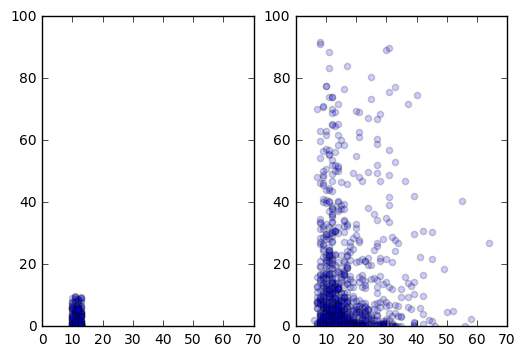

In [59]:
plt.figure(1)
plt.subplot(121)
plt.scatter(df_samp.AGE_YRS, df_samp.func_perc_fd, alpha=.2)
plt.ylim(0, 100)
plt.xlim(0, 70)
plt.subplot(122)
plt.ylim(0, 100)
plt.xlim(0, 70)
blah = plt.scatter(df.AGE_YRS, df.func_perc_fd, alpha=.2)

In [60]:
n=30
# Shuffle these remaining participants to ensure you get different sub
# samples each time you run the code.
df_samp_rand = df_samp.reindex(np.random.permutation(df_samp.index))

# Only keep the top 2*n participants.
df_samp_2n = df_samp_rand.iloc[:2*n, :]

# Sort these participants according to the sort columns of interest
sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']
df_samp_2n_sorted = df_samp_2n.sort_values(by=sort_column_list)

# Now put all even numbered participants in group A and all odd numbered
# participants in group B.
df_grp_A = df_samp_2n_sorted.iloc[::2, :]
df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

In [61]:
(df_grp_A.subject.shape,
df_grp_B.subject.shape)

((30,), (30,))

In [62]:
n=150
# Shuffle these remaining participants to ensure you get different sub
# samples each time you run the code.
df_samp_rand = df_samp.reindex(np.random.permutation(df_samp.index))

# Only keep the top 2*n participants.
df_samp_2n = df_samp_rand.iloc[:2*n, :]

# Sort these participants according to the sort columns of interest
sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']
df_samp_2n_sorted = df_samp_2n.sort_values(by=sort_column_list)

# Now put all even numbered participants in group A and all odd numbered
# participants in group B.
df_grp_A = df_samp_2n_sorted.iloc[::2, :]
df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

In [63]:
(df_grp_A.subject.shape[0],
df_grp_B.subject.shape[0])

(94, 94)

It appears that, at least in this slice (age 10-13, < 10% bad volumes), we only have a maximum of 94\*2=188 subjects to work with, and so every iteration with these cutoffs, we're just remixing this subsample. As we increase our motion cuttoff, or rather reduce its stringency, we increase our available sampling pool

In [64]:
def split_two_matched_samples(df, motion_thresh, age_l, age_u, n):
    """
    This function takes in a data frame, thresholds it to only include
    participants whose percentage bad frames are less than motion_thresh
    and participants who are between the lower and upper age limits (inclusive),
    then returns two matched samples of size n. The samples are matched on
    age in years, autism diagnosis, gender and scanning site.
    Information about the motion measure is here:
    http://preprocessed-connectomes-project.org/quality-assessment-protocol/
    """

    # Start by removing all participants whose data is below a certain
    # motion threshold.
    df_samp_motion = df.loc[df['func_perc_fd'] < motion_thresh, :]

    # Then remove participants who are younger (in years) than age_l and older
    # than age_u. Note that this means people who are age_l and age_u
    # (eg 6 and 10) will be included in the sample.
    df_samp = df_samp_motion.loc[(df_samp_motion['AGE_YRS']>=age_l)
                                    & (df_samp_motion['AGE_YRS']<=age_u), :]

    # Shuffle these remaining participants to ensure you get different sub
    # samples each time you run the code.
    df_samp_rand = df_samp.reindex(np.random.permutation(df_samp.index))

    # Only keep the top 2*n participants.
    df_samp_2n = df_samp_rand.iloc[:2*n, :]

    # Sort these participants according to the sort columns of interest
    sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']
    df_samp_2n_sorted = df_samp_2n.sort_values(by=sort_column_list)

    # Now put all even numbered participants in group A and all odd numbered
    # participants in group B.
    df_grp_A = df_samp_2n_sorted.iloc[::2, :]
    df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

    # Boom! Return these two data frames
    return df_grp_A, df_grp_B


Let's look at how often a particular subject ID re-occurs at different sample sizes.

In [72]:
motion_thresh = 10; age_l = 10; age_u = age_l + 3
n_perms = 500

proportionDF = pd.DataFrame()

for motion_thresh in range(5, 55, 5):
    for n in range(30, 330, 30):
        subs = None
        for i in range(n_perms):
            #create two matched samples split on motion_thresh, age upper, age lower, and n
            df_A, df_B = split_two_matched_samples(df, motion_thresh, age_l, age_u, n)
            subs = pd.concat([subs, df_A.loc[:, 'subject'], df_B.loc[:, 'subject']])
        proportionDF = proportionDF.append(
            {'motion_thresh' : motion_thresh, 
             'N_set' : n*2,
             'N_obs' : subs.shape[0]/n_perms,
             'prop_min' : float(subs.value_counts().min())/n_perms,
             'prop_max' : float(subs.value_counts().max())/n_perms},
            ignore_index=True)

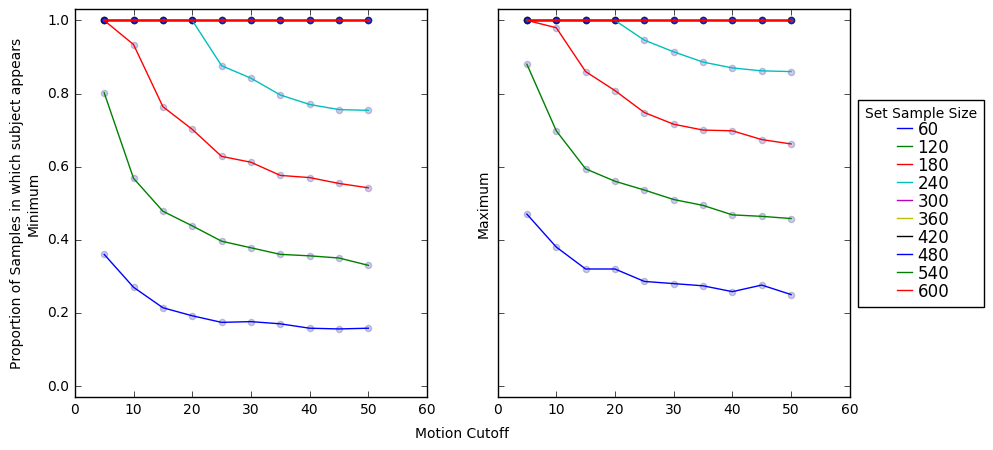

In [77]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF.query("N_set == " + str(N_set))
    propPlotAx[0].scatter(tmpPropDF.motion_thresh, tmpPropDF.prop_min, alpha=.2)
    propPlotAx[0].plot(tmpPropDF.motion_thresh, tmpPropDF.prop_min)
    propPlotAx[1].scatter(tmpPropDF.motion_thresh, tmpPropDF.prop_max, alpha=.2)
    propPlotAx[1].plot(tmpPropDF.motion_thresh, tmpPropDF.prop_max)
    labels.append(N_set)

handles, labels_trash = propPlotAx[1].get_legend_handles_labels()
propPlotAx[0].set_ylim([-.03, 1.03])
propPlotAx[0].set_xlabel('Motion Cutoff')
propPlotAx[0].xaxis.set_label_coords(1.1, -.075)
propPlotAx[0].set_ylabel('Proportion of Samples in which subject appears\nMinimum')
propPlotAx[1].set_ylabel('\nMaximum')
propPlotAx[1].legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

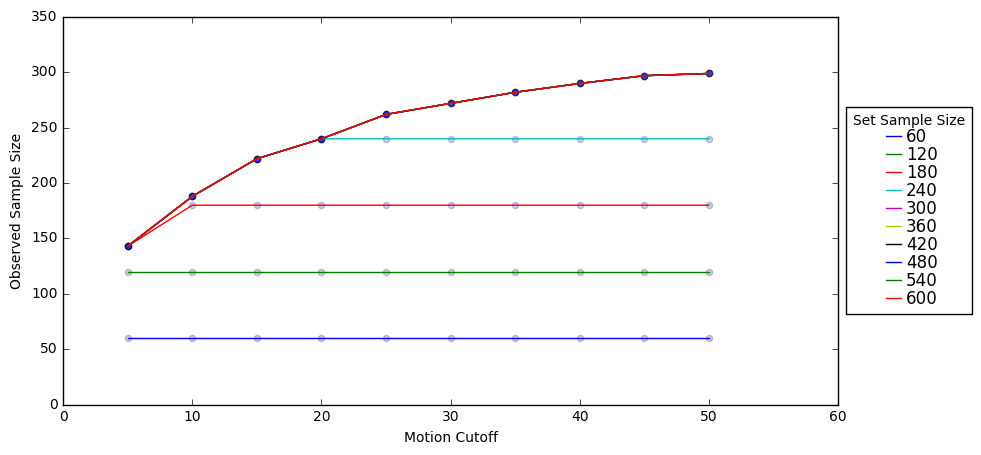

In [78]:
propPlotFig, propPlotAx = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
propPlotFig.set_size_inches(10, 5)

labels = []
for N_set in range(30*2, 330*2, 30*2):
    tmpPropDF = proportionDF.query("N_set == " + str(N_set))
    propPlotAx.scatter(tmpPropDF.motion_thresh, tmpPropDF.N_obs, alpha=.2)
    propPlotAx.plot(tmpPropDF.motion_thresh, tmpPropDF.N_obs)
    labels.append(N_set)

handles, labels_trash = propPlotAx.get_legend_handles_labels()
propPlotAx.set_xlabel('Motion Cutoff')
propPlotAx.set_ylabel('Observed Sample Size')
propPlotAx.legend(handles, labels, ncol=1, loc='center left',
                   title = "Set Sample Size", 
           bbox_to_anchor=[1, .5], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=False, shadow=False)

## Conclusion

We're not actually able to iterate over sample size very well. Also, at low motion cutoffs, and high sample sizes, we're merely shuffling groups in each iteration. This might be helped by looking at a single, wide age range (the above is just ages 10-13), or bootstrap sampling with replacement.